<a href="https://colab.research.google.com/github/Arif-PhyChem/trace_conservation/blob/main/hc_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Arif-PhyChem/trace_conservation/blob/main/hc_pinn.ipynb)

In [1]:
import sys
import os

! git clone https://github.com/Arif-PhyChem/MLQD.git

Cloning into 'MLQD'...
remote: Enumerating objects: 1044, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 1044 (delta 162), reused 217 (delta 103), pack-reused 724 (from 1)
Receiving objects: 100% (1044/1044), 34.99 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (454/454), done.
Updating files: 100% (80/80), done.


In [2]:
# install the required packages

! pip install tensorflow --upgrade
! pip install sklearn
! pip install hyperopt

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
# Add MLQD's path to system path

mlqd_dir='MLQD/dev_ver'
sys.path.append(mlqd_dir)

from evolution import quant_dyn



In [4]:
# get training and test data files from github
! git clone https://github.com/Arif-PhyChem/trace_conservation.git

Cloning into 'trace_conservation'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 190 (delta 40), reused 0 (delta 0), pack-reused 110 (from 1)
Receiving objects: 100% (190/190), 202.42 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Updating files: 100% (38/38), done.


# Physics Informed Neural Networks (PINNs) with uncertainity-aware hard coded (HC) trace constraint

In the case of PINNs (Physics-Informed Neural Networks), physical constraints are integrated into the loss function through an additional loss term, $\mathcal{L}_\text{Tr}$, which penalizes deviations from trace conservation. Although PINNs significantly improve trace conservation compared to purely data-driven NNs, they can still exhibit minor violations. This is because the physical constraints in the PINNs loss function are typically considered "soft." In simpler terms, PINNs are encouraged to satisfy the constraints during training, but these constraints are not strictly enforced.

To overcome the limitations of PINNs, we employ a novel approach that enforces trace conservation by design. This approach utilizes a U-aware HC (uncertainty-aware hard-coded) constraint, guaranteeing strict adherence to physical laws during simulations. Unlike PINNs, the U-aware HC constraint operates independently of the loss function, allowing for a more direct and rigorous enforcement of the trace conservation law, thereby rectifying potential violations during the simulation process.

To facilitate the training process, we provide pre-prepared training files named 'x.npy' and 'y.npy'. However, if you wish to create your own training files, you can use the MLQD tool, available on GitHub at [MLQD GitHub](https://github.com/Arif-PhyChem/MLQD), in conjunction with the SB dataset from the QD3SET-1 database, which can be accessed via this [DOI link](https://doi.org/10.25452/figshare.plus.c.6389553).

## PINN model with U-aware HC constraint for SB model with MLQD

For quick run, we are setting training epochs 'TrEpochs' to 10, you should set it to a higher number for better training. The uncertainty-aware HC constraint is integrated with priors set as $(p_1, p_2) = (0, 0.1)$.




In [5]:
# sb training files (x and y) for HC_PINN NN provided at Zenodo
! wget --content-disposition https://zenodo.org/records/13446756/files/training_data.zip?download=1

--2024-09-03 08:48:08--  https://zenodo.org/records/13446756/files/training_data.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380879719 (363M) [application/octet-stream]
Saving to: ‘training_data.zip’

training_data.zip   100%[===================>] 363.23M  26.0MB/s    in 15s     

2024-09-03 08:48:23 (24.3 MB/s) - ‘training_data.zip’ saved [380879719/380879719]



In [6]:
# Unzip it
! unzip training_data

Archive:  training_data.zip
   creating: training_data/
   creating: training_data/fmo/
   creating: training_data/fmo/hc_pinn/
  inflating: training_data/fmo/hc_pinn/x.npy  
  inflating: training_data/fmo/hc_pinn/y01.npy  
   creating: training_data/fmo/physics_agnostic/
   creating: training_data/fmo/physics_agnostic/site_1/
  inflating: training_data/fmo/physics_agnostic/site_1/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_1/y.npy  
   creating: training_data/fmo/physics_agnostic/site_2/
  inflating: training_data/fmo/physics_agnostic/site_2/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_2/y.npy  
   creating: training_data/fmo/physics_agnostic/site_3/
  inflating: training_data/fmo/physics_agnostic/site_3/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_3/y.npy  
   creating: training_data/fmo/physics_agnostic/site_4/
  inflating: training_data/fmo/physics_agnostic/site_4/x.npy  
  inflating: training_data/fmo/physics_agnostic/site_4/y.npy  

In [7]:
# input for MLQD package, more details are given at https://github.com/Arif-PhyChem/MLQD

#Training for prior 0

param={
    'n_states': 2,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/sb/pinn/x',  # str: (Optional) The prepared X file
      'YfileIn': 'training_data/sb/pinn/y',  # str: (Optional) The prepared Y file
      'hyperParam': 'False',  # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'pinn': 'True',   # model is physics-informed
      'prior': 0,
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'SB'
    }
quant_dyn(**param)
# Define the directory containing the models
directory = 'trained_models'

# Iterate through all files in the directory
for filename in os.listdir(directory):
  if filename.startswith("SB") and filename.endswith('.keras'):  # Check if the file is a model file
    # Construct the new filename with 'site' prefixed
    new_filename = 'prior_0'  + '_' + filename
    # Construct full file paths
    old_file = os.path.join(directory, filename)
    new_file = os.path.join(directory, new_filename)
    # Rename the file
    os.rename(old_file, new_file)
    print(f'Renamed: {old_file} to {new_file}')

# Training for prior 0.1 (You can optimize model by providing 'hyperParam': True)
param={
    'n_states': 2,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/sb/hc_pinn/x',  # str: (Optional) The prepared X file
      'YfileIn': 'training_data/sb/hc_pinn/y01',  # str: (Optional) The prepared Y file
      'hyperParam': 'False',  # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'pinn': 'True',   # model is physics-informed
      'prior': 0.1,
      'patience': 30,
      'OptEpochs': 10,
      'TrEpochs': 10,
      'max_evals': 10,
      'systemType': 'SB'
      }
quant_dyn(**param)

# Iterate through all files in the directory
for filename in os.listdir(directory):
  if filename.startswith("SB") and filename.endswith('.keras'):  # Check if the file is a model file
    # Construct the new filename with 'site' prefixed
    new_filename = 'prior_01'  + '_' + filename
    # Construct full file paths
    old_file = os.path.join(directory, filename)
    new_file = os.path.join(directory, new_filename)
    # Rename the file
    os.rename(old_file, new_file)
    print(f'Renamed: {old_file} to {new_file}')

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory trained_models created sucessfully where the trained models will be saved
Epoch 1/10
Running with custom loss: mse + trace penalty term
Running with custom loss: mse + trace penalty term
Running with custom loss: mse + trace penalty term

Epoch 1: val_loss improved from inf to 0.00885, saving model to trained_models/SB_cnn_model-01-tloss-1.355e-01-vloss-8.847e-03.keras
90/90 - 17s - 188ms/step - loss: 0.1355 - val_loss: 0.0088
Epoch 2/10

Epoch 2: val_loss improved from 0.00885 to 0.00570, saving model to trained_models/SB_cnn_model-02-tloss-7.086e-03-vloss-5.702e-03.keras
90/90 - 10s - 112ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 3/10

Epoch 3: val_loss improved from 0.00570 to 0.00335, saving model to trained_models/SB_cnn_model-03-tloss-4.112e-03-vloss-3.354e-03.keras
90/90 - 12s - 138ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/10

Epoch 4: val_loss improved from 0.00335 to 0.00231, saving model to trained_models/SB_cnn_model-04-tloss-2.511e-03-vloss-2.310e-03.

## Test for a test trajectory.

In [ ]:
# test tarjectory
! ls trace_conservation/test_data/sb/

2_epsilon-0.0_Delta-1.0_lambda-0.6_gamma-9.0_beta-1.0.npy


In [13]:
# Grab trained SB models for all priors with max epoch number

from datetime import datetime

# Directory containing the models
model_dir = "trained_models"

# List all models in the directory
models_1 = [f for f in os.listdir(model_dir) if f.startswith("prior_0_") and f.endswith(".keras")]
models_2 = [f for f in os.listdir(model_dir) if f.startswith("prior_01_") and f.endswith(".keras")]

prior_0_models = {}
prior_01_models = {}  # prior 0.1

for model in models_1:
  epoch_number = int(model.split("-")[1])
  prior_0_models[epoch_number] = model
for model in models_2:
  epoch_number = int(model.split("-")[1])
  prior_01_models[epoch_number] = model

# Find the maximum epoch number
max_epoch = max(prior_0_models.keys())

# Get the model with the largest epoch number
max_epoch_model_4_prior_0 = prior_0_models[max_epoch]

print("Model with the largest epoch for prior 0:", max_epoch_model_4_prior_0)

max_epoch = max(prior_01_models.keys())

# Get the model with the largest epoch number
max_epoch_model_4_prior_01 = prior_01_models[max_epoch]

print("Model with the largest epoch for prior 0.1:", max_epoch_model_4_prior_01)

Model with the largest epoch for prior 0: prior_0_SB_cnn_model-10-tloss-1.548e-04-vloss-1.444e-04.keras
Model with the largest epoch for prior 0.1: prior_01_SB_cnn_model-10-tloss-2.256e-04-vloss-1.589e-04.keras


In [15]:
# Here we are using MLQD for dynamics prediction, later we will calculate the
import numpy as np
import matplotlib.pyplot as plt
xx = np.load('trace_conservation/test_data/sb/2_epsilon-0.0_Delta-1.0_lambda-0.6_gamma-9.0_beta-1.0.npy')
x = xx[0:41,1:]

trained_models= 'trained_models/'+str(max_epoch_model_4_prior_0) + ', ' + 'trained_models/'+str(max_epoch_model_4_prior_01)

param={
    'n_states': 2,
    'time': 10,
    'ostl_steps': 20,
      'QDmodel': 'useQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'XfileIn': x,           # input x file
      'gamma': 9.0, # characteristic frequency of the test trajectory
      'lamb': 0.6,  # system-bath strength of the test trajectory
      'temp': 1.0, # beta = 1/T
      'prior': 0.1,
      'cons_trace': 'True', # Option for U-aware HC constraint
      'systemType': 'SB', # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO)
      'QDmodelIn':  trained_models,  # Trained models with prior 0 and prior 0.1
      'QDtrajOut': 'hc_sb_traj'  # predicted trajectory will be saved with this name
      }
quant_dyn(**param)


MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 165, 80)             │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 165, 110)            │          26,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 165, 80)             │          26,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 82, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         209,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 80)                  │          10,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,806 (1.06 MB)

 Trainable params: 277,806 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

         Model # 2        


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 165, 80)             │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 165, 110)            │          26,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 165, 80)             │          26,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 82, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │         209,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 80)                  │          10,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,806 (1.06 MB)

 Trainable params: 277,806 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Dynamics is saved in a file  "hc_sb_traj"
ml_dyn.RCDYN: Time taken = 2.276026487350464 sec
No reference trajectory was provided, so dynamics is not plotted. You can provide reference trajectory with "refTraj"
MLQD is ended at 2024-09-03 09:02:49.687363


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


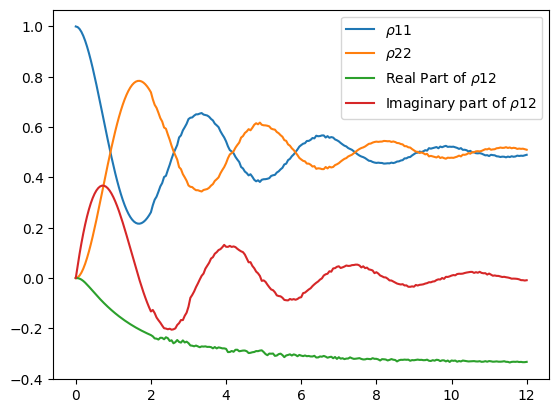

In [16]:
# Plot elements of rho
x = np.load('hc_sb_traj.npy')

plt.plot(x[:,0], x[:, 1], label=r'$\rho$11') # Population of state_1
plt.plot(x[:,0], x[:, 4], label=r'$\rho$22')  # Population of state_1
plt.plot(x[:,0], np.real(x[:, 2]), label=r'Real Part of $\rho$12') # Real part of coherent term r_12
plt.plot(x[:,0], np.imag(x[:, 2]), label=r'Imaginary part of $\rho$12') # Real part of coherent term r_21
plt.legend()

Text(0.5, 1.0, 'Trace in the case of symmetric SB model using PINN with U-aware HC constraint')

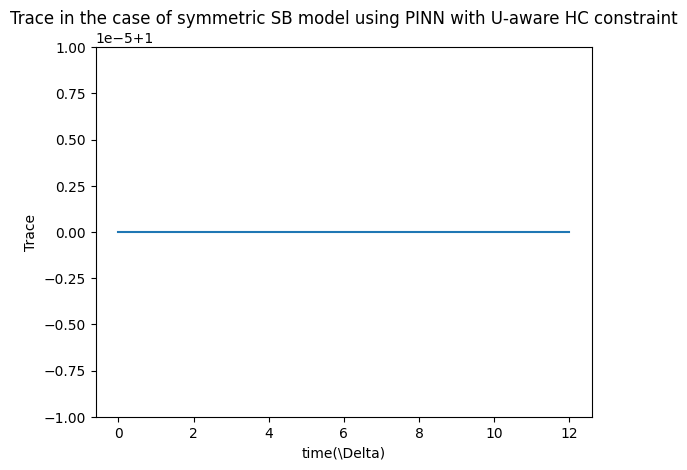

In [17]:
# Plot trace vs time
x = np.load('hc_sb_traj.npy')
trace = np.real(x[:,1] + x[:,4])

plt.plot(x[:,0], trace)
plt.xlabel('time(\Delta)')
plt.ylabel('Trace')
plt.ylim(0.99999, 1.00001)
plt.title('Trace in the case of symmetric SB model using PINN with U-aware HC constraint')

# Let's do it for FMO complex

In [ ]:
# input for MLQD package, more details are given at https://github.com/Arif-PhyChem/MLQD

# Training for prior 0
param={
    'n_states': 7,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/fmo/pinn/x',           # str: (Optional) The prepared X file
      'YfileIn': 'training_data/fmo/pinn/y',           # str: (Optional) The prepared Y file
      'hyperParam': 'False',           # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'prior': 0,
      'pinn': 'True',
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'FMO'
      }
quant_dyn(**param)
# Define the directory containing the models
directory = 'trained_models'

# Iterate through all files in the directory
for filename in os.listdir(directory):
  if filename.startswith("FMO") and filename.endswith('.keras'):  # Check if the file is a model file
    # Construct the new filename with 'site' prefixed
    new_filename = 'prior_0'  + '_' + filename
    # Construct full file paths
    old_file = os.path.join(directory, filename)
    new_file = os.path.join(directory, new_filename)
    # Rename the file
    os.rename(old_file, new_file)
    print(f'Renamed: {old_file} to {new_file}')

# Training for prior 0.1 (You can optimize model by providing 'hyperParam': True)
param={
    'n_states': 7,
      'QDmodel': 'createQDmodel',     # str: create QD model. The dafault option is useQDmodel
      'QDmodelType': 'RCDYN',           # str: The type of model. Here KRR and the default option is OSTL
      'prepInput' : 'False',           # str: Prepare input files from the data (Default 'False')
      'XfileIn': 'training_data/fmo/hc_pinn/x',           # str: (Optional) The prepared X file
      'YfileIn': 'training_data/fmo/hc_pinn/y01',           # str: (Optional) The prepared Y file
      'hyperParam': 'False',           # str: Default is 'False', we can pass 'True' (optimize the hyperparameters) or 'False' (don't optimize and run with the default values)
      'prior': 0.1,
      'pinn': 'True',
      'patience': 30,
      'OptEpochs': 30,
      'TrEpochs': 10,
      'max_evals': 30,
      'systemType': 'FMO'
      }
quant_dyn(**param)

# Iterate through all files in the directory
for filename in os.listdir(directory):
  if filename.startswith("FMO") and filename.endswith('.keras'):  # Check if the file is a model file
    # Construct the new filename with 'site' prefixed
    new_filename = 'prior_0'  + '_' + filename
    # Construct full file paths
    old_file = os.path.join(directory, filename)
    new_file = os.path.join(directory, new_filename)
    # Rename the file
    os.rename(old_file, new_file)
    print(f'Renamed: {old_file} to {new_file}')

MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
Running with custom loss: mse + trace penalty term
Running with custom loss: mse + trace penalty term
Running with custom loss: mse + trace penalty term

Epoch 1: val_loss improved from inf to 0.00418, saving model to trained_models/FMO_cnn_model-01-tloss-4.346e-02-vloss-4.184e-03.keras
105/105 - 167s - 2s/step - loss: 0.0435 - val_loss: 0.0042
Epoch 2/10

Epoch 2: val_loss improved from 0.00418 to 0.00202, saving model to trained_models/FMO_cnn_model-02-tloss-2.838e-03-vloss-2.018e-03.keras
105/105 - 152s - 1s/step - loss: 0.0028 - val_loss: 0.0020
Epoch 3/10

Epoch 3: val_loss improved from 0.00202 to 0.00126, saving model to trained_models/FMO_cnn_model-03-tloss-1.645e-03-vloss-1.264e-03.keras
105/105 - 153s - 1s/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/10

Epoch 4: val_loss improved from 0.00126 to 0.00100, saving model to trained_models/FMO_cnn_model-04-tloss-1.199e-03-vloss-9.994e-04.keras
105/105 - 220s - 2s/step - loss: 0.0012 - val_loss: 9.9937e-04
Epoch 5/10


In [8]:
# Grab trained SB models for all states with max epoch number

from datetime import datetime

# Directory containing the models
model_dir = "trained_models"

# List all models in the directory
models_1 = [f for f in os.listdir(model_dir) if f.startswith("prior_0_") and f.endswith(".keras")]
models_2 = [f for f in os.listdir(model_dir) if f.startswith("prior_01_") and f.endswith(".keras")]

prior_0_models = {}
prior_01_models = {}  # prior 0.1

for model in models_1:
  epoch_number = int(model.split("-")[1])
  prior_0_models[epoch_number] = model
for model in models_2:
  epoch_number = int(model.split("-")[1])
  prior_01_models[epoch_number] = model

# Find the maximum epoch number
max_epoch = max(prior_0_models.keys())

# Get the model with the largest epoch number
max_epoch_model_4_prior_0 = prior_0_models[max_epoch]

print("Model with the largest epoch for prior 0:", max_epoch_model_4_prior_0)

max_epoch = max(prior_01_models.keys())

# Get the model with the largest epoch number
max_epoch_model_4_prior_01 = prior_01_models[max_epoch]

print("Model with the largest epoch for prior 0.1:", max_epoch_model_4_prior_01)

Model with the largest epoch for prior 0: prior_01_SB_cnn_model-10-tloss-2.256e-04-vloss-1.589e-04.keras
Model with the largest epoch for prior 0.1: prior_01_SB_cnn_model-10-tloss-2.256e-04-vloss-1.589e-04.keras


In [ ]:
xx = np.load('trace_conservation/test_data/fmo/7_initial-1_gamma-400.0_lambda-40.0_temp-90.0.npy')

x = xx[0:41,1:]
trained_models= 'trained_models/' + str(max_epoch_model_4_prior_0) + ', ' + 'trained_models'+str(max_epoch_model_4_prior_01)
param={
        'n_states': 7,
        'time': 2,
        'ostl_steps': 20,
        'QDmodel': 'useQDmodel',     # str: create QD model. The dafault option is useQDmodel
        'QDmodelType': 'RCDYN',           # str: The type of model. Here RCDYN and the default option is OSTL
        'XfileIn': x,           # The input x
        'gamma': 400,    # Characteristic frequency (cm-1)
        'lamb': 40,     # System-bath coupling (cm-1)
        'temp': 90,     # Temperature (K)
        'cons_trace': 'True',
        'systemType': 'FMO', # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO)
        'QDmodelIn': trained_models,    # Trained model
        'QDtrajOut': 'hc_fmo_traj'  # predicted trajectory will be saved with this name
      }
quant_dyn(**param)


MLQD is a python package developed for Machine Learning-based Quantum Dissipative Dynamics,
 				  Version 1.1.1
			 https://github.com/Arif-PhyChem/MLQD

 			 Copyright (c) 2023 Arif Ullah

All rights reserved. This work is licensed under the Apache Software License 2.0


The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software.


The software is provided "as is" without warranty of any kind, express or implied, 
including but not limited to the warranties ofmerchantability, fitness for a particular 
purpose and noninfringement. In no event shall the authors or copyright holders be 
liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, 
arising from, out of or in connection with the software or the use or other dealings in the software.


				 Cite as:

1) Ullah A. and Dral P. O., Computer Physics Communications, 2023, 294, 108940
2) Ullah A. and Dral P. O., New Journ

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 2010, 80)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 2010, 110)           │          26,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 2010, 80)            │          26,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1005, 80)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 80400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │       2,572,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 980)                 │         126,420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,756,786 (10.52 MB)

 Trainable params: 2,756,786 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

         Model # 2        


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 2010, 80)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 2010, 110)           │          26,510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 2010, 80)            │          26,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1005, 80)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 80400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │       2,572,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 980)                 │         126,420 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,756,786 (10.52 MB)

 Trainable params: 2,756,786 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

ml_dyn.RCDYN: Running recursive dynamics with CNN model......
ml_dyn.RCDYN: Dynamics is saved in a file  "hc_fmo_traj"
ml_dyn.RCDYN: Time taken = 2.3742995262145996 sec
No reference trajectory was provided, so dynamics is not plotted. You can provide reference trajectory with "refTraj"
MLQD is ended at 2024-09-03 06:09:38.882463


Text(0.5, 0, 'time(ps)')

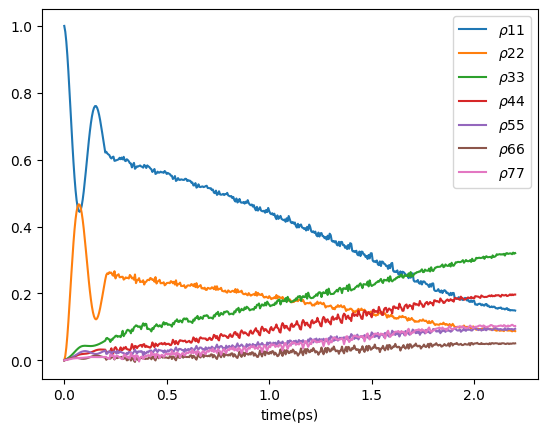

In [ ]:
# Plotting diagonal terms of rho
x = np.load('hc_fmo_traj.npy')

label=1
for i in [1, 9, 17, 25, 33, 41, 49]:
  plt.plot(x[:,0], x[:, i], label=r'$\rho$'+str(label)+str(label))
  label += 1
plt.legend()
plt.xlabel('time(ps)')

Text(0, 0.5, 'Trace')

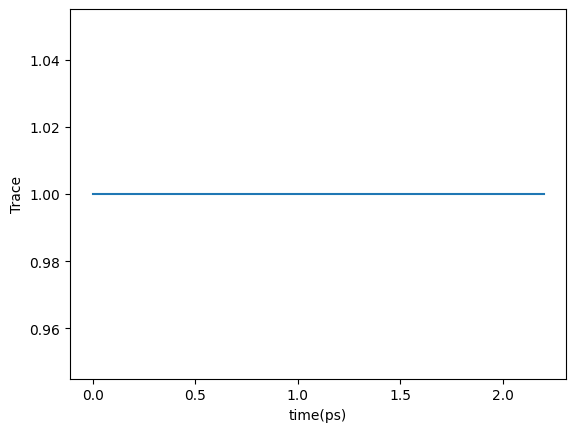

In [ ]:
# Plot trace vs time

x = np.load('hc_fmo_traj.npy')
trace = 0.0
for i in [1, 9, 17, 25, 33, 41, 49]:
  trace += np.real(x[:,i])

plt.plot(x[:,0], trace)
plt.xlabel('time(ps)')
plt.ylabel('Trace')